In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
from model_manager import ModelManager

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 874866104


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 10,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 200,
    "to_freeze_count": 150
}

optuna_result_attachement = {
    'lr': 0.001,
    'lr_end': 0,
    'power': 0.72,
    'scheduler': 'polynomial_decay_schedule_with_warmup',
    'warmup_factor': 0
}
config.update(optuna_result_attachement)
config

{'model_name': 'EleutherAI/gpt-neo-125M',
 'lr': 0.001,
 'warmup_factor': 0,
 'scheduler': 'polynomial_decay_schedule_with_warmup',
 'lr_end': 0,
 'power': 0.72,
 'freeze_from_steps': -1,
 'seed': 874866104,
 'num_epoch': 200,
 'to_freeze_count': 150}

In [5]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
***** Running training *****
  Num examples = 1222
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7800


[0] set freeze_part_layers: True (freezing 150 out of 160 layers.)


Step,Training Loss
39,3.568200
78,1.924500
117,1.834200
156,1.731100
195,1.676900
234,1.619600
273,1.545100
312,1.446600
351,1.389000
390,1.341000


Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-500
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-500/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-1000
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-1000/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-1500
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-1500/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/awsw_main/checkpoint-500] due to args.save_total_limit
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-2000
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-2000/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint

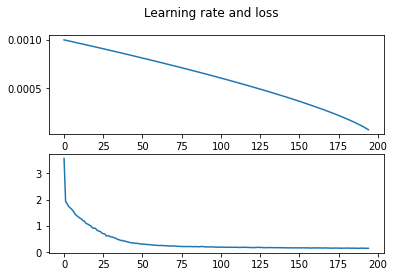

In [6]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [7]:
train_results['model'].eval()
model_manager = ModelManager(model=train_results['model'], tokenizer=train_results['tokenizer'])

In [8]:
prompts = [
    ('PlayerReply c "Hey Remy!" DragonReply Ry "Hey!"', "How are you?"),
    ('PlayerReply c "I was with Lorem today." DragonReply Ad "Very nice."', "What do you think of Lorem?"),
    ('DragonReply m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('DragonReply m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: Ry "Well, I'm fine." PlayerReply c "Likewise."<|endoftext|>


Prompt: What do you think of Lorem?
Reply: Ad "It's good to see you! At least you're not working as hard as I like to."<|endoftext|>


Prompt: Oh my god, Adine. What is this?
Reply: An "Who isomename?"<|endoftext|>


Prompt: What will we do here?
Reply: An "We can just leave."<|endoftext|>




# Sampling test

Which combination is the best?

In [ ]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 79, top_p: 0.45] -> Prompt: How are you?
Reply: Ry "It's my roommate." DragonReply Ry "Well, that's the best thing that's happened to me." Ry "I just thought you might want to get away from him a little." Ry "Afterwards, I figured you might want to get away from him a little." Ry "Afterwards, I��onge not wanted to talk to someone I'd call you." Ry " Noticed how very nice of you." Ry " Krug" DragonReply m "No matter what you might think about him..." Ry "

[Test 1 top_k: 79, top_p: 0.45] -> Prompt: What do you think of Lorem?
Reply: Ad "It's good to see you! At least you're not working overtime." PlayerReply c "I thought you might have some postmanoline in the cabinet." DragonReply Ad "Oh, I see. I'm just not sure if I can do that anymore."<|endoftext|>

[Test 1 top_k: 79, top_p: 0.45] -> Prompt: Oh my god, Adine. What is this?
Reply: An "Who is that?"<|endoftext|>

[Test 1 top_k: 79, top_p: 0.45] -> Prompt: What will we do here?
Reply: An "We can just leave."<|endoftext|

In [ ]:
model_manager = ModelManager(checkpoint_dirs[-1])
print("What to say?")
print(generate_dragon_reply("", input()))